## DQN HER Implementation

In [1]:
%matplotlib inline

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from collections import namedtuple
from itertools import count

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bit flipping environment

In [6]:
class BitFlipEnv():
    
    def __init__(self, n = 8):
        '''
        Setup the environment with a init state and target state
        The init and target stae should not be equal
        '''
        self.n = n
        self.init_state = torch.randint(2, size=(n,))
        self.target_state = torch.randint(2, size=(n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(n,))
        self.curr_state = self.init_state.clone()
        
    def step(self, action):
        '''
        Take a step, i.e. flip the bit specified by the position action
        Return the next state and the reward 
        Reward is 0 if the target state is reacher
        Otherwise reward is -1
        '''
        self.curr_state[action] = 1 - self.curr_state[action]
        if np.array_equal(self.curr_state, self.target_state):
            return self.curr_state.clone(), 0
        else:
            return self.curr_state.clone(), -1
        
    def reset(self):
        '''
        Reset the bit flip environment
        '''
        self.init_state = torch.randint(2, size=(self.n,))
        self.target_state = torch.randint(2, size=(self.n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(self.n,))
        self.curr_state = self.init_state.clone()

In [7]:
env = BitFlipEnv(n=10)

In [8]:
#testing the bit flip env
print('Initial state:', env.init_state)
print('Target state:', env.target_state)
curr_state, reward = env.step(9)
print('State, reward after taking action 9:', curr_state, reward)
print(type(curr_state))
env.reset()

Initial state: tensor([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.])
Target state: tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.])
State, reward after taking action 9: tensor([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.]) -1
<class 'torch.Tensor'>


## Replay Memory

HER Capable replay memory, i.e. additionally store the goal state for each transition

In [9]:

Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity = 1e5):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        """Saves a transition which should contain:
        - current state
        - action taken
        - next state
        - reward obtained
        - goal state"""
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
#             print('!!!!!memory capacity exceeded!')
            del self.memory[0]

    def sample(self, batch_size):
        """
        Returns batch_size number of samples from the replay memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## Model Definition
A feedforward NN with 1 hidden layer of size 256

In [10]:
NUM_BITS = 8
HIDDEN_SIZE = 256 

In [11]:
class FNN(nn.Module):
    
    def __init__(self):
        super(FNN, self).__init__()
        self.ln1 = nn.Linear(NUM_BITS*2, HIDDEN_SIZE)
        self.ln2 = nn.Linear(HIDDEN_SIZE, NUM_BITS)
        
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
    

## Hyper parameters

In [12]:
BATCH_SIZE = 128 # batch size for training
GAMMA = 0.999 # discount factor
EPS_START = 0.95 # eps greedy parameter
EPS_END = 0.05
TARGET_UPDATE = 50 # number of epochs before target network weights are updated to policy network weights
steps_done = 0 # for decayin eps

## Initialize Model
Initialize a policy network and a target network

In [13]:
policy_net = FNN().to(device)
target_net = FNN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1e6) 

## Helper functions

In [14]:
def select_action(state, goal, greedy=False):
    '''
    Select an action given the state and goal acc to policy_net
    - use eps_greedy policy when greedy=False
    - use greedy policy when greedy=True
    Returns action taken which is from range(0, n-1)
    '''
    global steps_done
    sample = random.random()
    state_goal = torch.cat((state, goal))

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
#     if steps_done % 1000 == 0:
#         print('Steps done: {} Epsilon threshold: {}'.format(steps_done, eps_threshold))
    if greedy:
        with torch.no_grad():
            return policy_net(state_goal).argmax().view(1,1)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_goal).argmax().view(1,1)
    else: 
        return torch.tensor([[random.randrange(NUM_BITS)]], device=device, dtype=torch.long)

In [15]:
def optimize_model():
    '''
    optimize the model, i.e. perform one step of Q-learning using BATCH_SIZE number of examples
    '''
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                           batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state 
                                      if s is not None])
    
    # extract state, action, reward, goal from randomly sampled transitions
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    goal_batch = torch.stack(batch.goal)
    
    # concatenate state and goal for network input
    state_goal_batch = torch.cat((state_batch, goal_batch), 1)
    non_final_next_states_goal = torch.cat((non_final_next_states, goal_batch), 1)
    
    # get current state action values 
    state_action_values = policy_net(state_goal_batch).gather(1, action_batch)
    
    # get next state values according to target_network
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states_goal).max(1)[0].detach()
    
    # calculate expected q value of current state acc to target_network
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()
    
    # find huber loss using curr q-value and expected q-value
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [16]:
# named tuple for storing the hindsight transitions, i.e. without goal state
HindsightTransition = namedtuple('HindsightTransition', 
                       ('state', 'action', 'next_state', 'reward'))

In [17]:
CHECK_RATE = 100 # evaluate success on the last 100 episodes
MODEL_PATH = '_her_policy_net.pt'
WEIGHTS_PATH = '_her_policy_net_weights.pt'
FIGURE_PATH = '_her.png'
SAVE_MODEL = True
LOAD_MODEL = False
num_episodes = 3000
EPS_DECAY = num_episodes * NUM_BITS * 0.05 # decay rate
print(EPS_DECAY)

1200.0


In [18]:
env = BitFlipEnv(NUM_BITS)
success = 0
episodes = [] # every 100 episodes
success_rate = [] # append success rate of last 100 episodes
# train the network
for i_episode in range(num_episodes):
    env.reset()
    state = env.init_state
    goal = env.target_state
    transitions = []
    episode_success = False
    # for bit length
    for t in range(NUM_BITS):
        
        if episode_success:
            continue
        
        action = select_action(state, goal)
        next_state, reward = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # add transition to replay memory
        memory.push(state, action, next_state, reward, goal)
        
        # store transition without goal state for hindsight 
        transitions.append(HindsightTransition(state, action, next_state, reward))

        state = next_state
        
        optimize_model()
        if reward == 0:
            if episode_success:
                continue
            else:
                episode_success = True
                success += 1
    
    # add hindsight transitions to the replay memory
    if not episode_success:
        # failed episode store the last visited state as new goal
        new_goal_state = state.clone()
        if not np.array_equal(new_goal_state, goal):
            for i in range(NUM_BITS):
                # if goal state achieved
                if np.array_equal(transitions[i].next_state, new_goal_state):
                    memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, torch.tensor([0]), new_goal_state)
                    optimize_model()
                    break

                memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, transitions[i].reward, new_goal_state)
                optimize_model()

    # update the target networks weights 
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if i_episode % CHECK_RATE == 0:
        print('success rate for last {} episodes after {} episodes of training: {}%'.format(CHECK_RATE, i_episode, success/CHECK_RATE * 100))
        success_rate.append(success/CHECK_RATE)
        episodes.append(i_episode)
        success = 0

episodes.append(num_episodes)
success_rate.append(success/CHECK_RATE)

success rate for last 100 episodes after 0 episodes of training: 0.0%
success rate for last 100 episodes after 100 episodes of training: 3.0%
success rate for last 100 episodes after 200 episodes of training: 14.000000000000002%
success rate for last 100 episodes after 300 episodes of training: 31.0%
success rate for last 100 episodes after 400 episodes of training: 53.0%
success rate for last 100 episodes after 500 episodes of training: 63.0%
success rate for last 100 episodes after 600 episodes of training: 76.0%
success rate for last 100 episodes after 700 episodes of training: 77.0%
success rate for last 100 episodes after 800 episodes of training: 91.0%
success rate for last 100 episodes after 900 episodes of training: 87.0%
success rate for last 100 episodes after 1000 episodes of training: 88.0%
success rate for last 100 episodes after 1100 episodes of training: 93.0%
success rate for last 100 episodes after 1200 episodes of training: 95.0%
success rate for last 100 episodes aft

## Plot the success rate across number of episodes

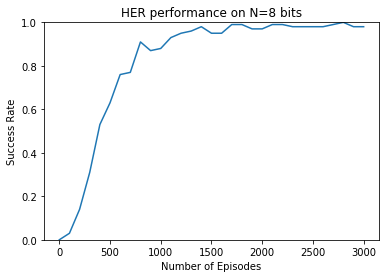

In [19]:
fig = plt.figure(1)
plt.plot(episodes, success_rate)
plt.title('HER performance on N={} bits'.format(NUM_BITS))
plt.ylabel('Success Rate')
plt.xlabel('Number of Episodes')
plt.ylim([0, 1])
if SAVE_MODEL:
    plt.savefig(str(NUM_BITS)+FIGURE_PATH)

## Save the model parameters

In [20]:
if SAVE_MODEL:
    torch.save(policy_net.state_dict(), str(NUM_BITS)+WEIGHTS_PATH)
    print('Weights saved')
    torch.save(policy_net, str(NUM_BITS)+MODEL_PATH)
    print('Model saved')

print('Complete')  

Weights saved
Model saved
Complete


/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/her/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Load the model parameters

In [21]:
LOAD_MODEL = False
if LOAD_MODEL:
    policy_net.load_state_dict(torch.load('final_weights/'+str(NUM_BITS)+WEIGHTS_PATH))

## Testing the model

In [22]:
successes = 0
for i in range(100):
    env.reset()
    test_state = env.init_state
    goal_state = env.target_state
#     print('#############################################')
#     print('start', test_state)
#     print('goal', goal_state)
    next_state = test_state.clone()
    for i in range(NUM_BITS):
        action = select_action(next_state, goal_state, greedy=True)
        next_state, reward = env.step(action.item())
#         print('taking action', action)
#         print('next state', next_state)
        if np.array_equal(next_state, goal_state):
            successes += 1
            break
print(successes)

99
